# A simple notebook to turn SAC to WAV files 

## How to set up directories, codes and files

Download obspyDMT into a local floder:
    
        git clone https://github.com/kasra-hosseini/obspyDMT.git /path/to/my/obspyDMT

obspyDMT can be installed by:

        cd /path/to/my/obspyDMT
        pip install -e .

Please **do not use** >>pip install obspyDMT<<. 

Copy **process_unit_wav.py** which you can find in this project folder into:
    
    /path/to/my/obspyDMT/obspyDMT

You will find there also some other files named **process_unitXXX.py** in this path.

## What else you will need to run this notebook

The usual suspects:

    Anaconda
    obspy
    numpy, scipy, ...
    cartopy 

The extras:
    
    SoundFile
    natsorted
    

## Useful links
    
   **Websites for finding earthquakes, networks and stations:**
    - http://www.fdsn.org/networks/
    - http://ds.iris.edu/wilber3/find_event
    
   **Understanding network codes:**
    - https://ds.iris.edu/ds/nodes/dmc/tools/data_channels/#???
    - https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/
    
   **How to quickly download earthquakes:**
    - https://github.com/kasra-hosseini/obspyDMT
    
   **Learn more about python, jupyter notebooks and obspy:**
    - http://seismo-live.org/
    
   **How to install Anaconda:**
    - https://docs.anaconda.com/anaconda/install/mac-os/
    
   **What we are using to export the waveforms to WAV files:**
    - https://pysoundfile.readthedocs.io/en/latest/

ATTENTION 1: 
It you have a "%%capture" at the top of the cell no output will be shown. If you are suspicious that something is going terribly wrong you can comment out this line and see the whole output again.

ATTENTION 2:
Basemap is deprecated in favor of the Cartopy project. 

## Import 

You usually do not change this part.

In [1]:
# solve issue wi\th autocomplete
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import os
import sys
import time
import glob
from IPython import display

from soundfile import SoundFile
from natsort import natsorted

import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
from obspy import read, Trace
from obspy.signal.tf_misfit import plot_tfr

# the file src_sac2wav contains written functions for exporting sac to wav files
from src_sac2wav import *

## Download the data

<img src="DMT_logo.png" width="200" align="center">

### Input for Download

In [27]:
# ==============
# DOWNLOAD input 
# ==============

save_path = '/mnt/seismodata2/MT/_OUTPUT_/test_obspyDMT_jupyter_final_v02'

# Choose between "event" and "continuous" or "day" mode.
# When you are choosing "continuous" or "day" mode, day files will be downloaded regardless of the mode. 
# In continuous mode the day files are later merged to one long trace and exported as WAV. 
mode = 'event'

# Does not download anything but just gives you a table of available events in the timespan you define in start_time/end_time
event_info = False

start_time = '2021-02-01'
end_time = '2021-05-03'

# preset and offset make only sense in event mode, will not be used with continuous or day mode!
preset = 300  # in [SEC] default: 0; put None if you want to use default values
offset = 7200  # default: 1800 for event-based mode and 0 for continuous mode

min_mag = '8.0'
max_mag = '10'

samplingrate = None  # or None 
waveform_format = 'sac'  # or mseed 

event_catalog = 'NEIC_USGS'
data_source = 'all'  # all or RESIF

network = 'EI'
station = 'DSB'
channel = 'B*'

# ATTENTION!! If this is set to TRUE and the datapath is found, delete it before running obspyDMT
reset = False

# parallel request is on default with 4 cores 
parallel_request = True

# parallel processing is on default with 4 cores
parallel_process = True

# instrument response, yes/no
instrument_correction = True

# process_unit that you want to use:
process_unit = 'process_unit_wav'

In [28]:
# output paths will be generated:
wav_save, save_fig_path = generate_output_folders(mode, save_path)

Generate the obspyDMT command first:

In [29]:
##### here the input from above is put together for obspyDMT 
execute_DMT = f'obspyDMT --datapath {save_path} --min_date {start_time} --max_date {end_time}'\
              f' --waveform_format {waveform_format} --data_source {data_source}'\
              f' --pre_process {process_unit}'

if mode == 'event':
    execute_DMT = execute_DMT + f' --min_mag {min_mag} --max_mag {max_mag}'\
                                f' --event_catalog {event_catalog}'

elif mode == 'continuous' or mode == 'day':
    execute_DMT = execute_DMT + f' --continuous '

else:
    sys.exit(f'Mode: {mode} not implemented. Forced exit!')

# if samplingrate is not None then add the sampling rate modifier otherwise it 
# should not change the sampling rate of the waveforms


if station == '*':
    # This means all channels are considered but some datacentres don't like the wildcard
    pass
elif station != '*':
    execute_DMT = execute_DMT + f' --sta {station}'

if channel == '*':
    pass
elif channel != '*':   
    execute_DMT = execute_DMT + f' --cha {channel}'

if network == '*':
    pass
elif network != '*':
    execute_DMT = execute_DMT + f' --net {network}'

if preset:
    execute_DMT = execute_DMT + f' --preset {preset}'

if offset:
    execute_DMT = execute_DMT + f' --offset {offset}'

if samplingrate: 
    execute_DMT = execute_DMT + f' --sampling_rate {samplingrate}'

if instrument_correction:
    execute_DMT = execute_DMT + f' --instrument_correction'

if parallel_request:
    execute_DMT = execute_DMT + f' --req_parallel --req_np 4'

if parallel_process:
    execute_DMT = execute_DMT + f' --parallel_process --process_np 4'

if event_info:
    execute_DMT = execute_DMT + f' --event_info'
    
if reset:
    execute_DMT = execute_DMT + f'  --reset'
        
print(f'Executing following command in the next cell:\n\n{execute_DMT}')

Executing following command in the next cell:

obspyDMT --datapath /mnt/seismodata2/MT/_OUTPUT_/test_obspyDMT_jupyter_final_v02 --min_date 2021-02-01 --max_date 2021-05-03 --waveform_format sac --data_source all --pre_process process_unit_wav --min_mag 8.0 --max_mag 10 --event_catalog NEIC_USGS --sta DSB --cha B* --net EI --preset 300 --offset 7200 --instrument_correction --req_parallel --req_np 4 --parallel_process --process_np 4


Attention! Only execute the next line if you want to download or update your dataset. If you just want to plot or export some specific data you already downloaded then you do not have to execute the next line!

In [30]:
!{execute_DMT}

/mnt/store/mariat/anaconda3/envs/py37/lib/python3.7/site-packages/obspy/clients/arclink/__init__.py:178: ObsPyDeprecationWarning: The ArcLink protocol will be deprecated in the near future. Please, use the client contacting the routing service provided by EIDA: https://docs.obspy.org/packages/obspy.clients.fdsn.html#basic-routing-clients-usage
  warnings.warn(msg, category=ObsPyDeprecationWarning)
--------------------------------------------------------------------------------
		   obspyDMT (obspy Data Management Tool)

	Python Toolbox for Retrieving, Processing and Management of
			Large Seismological Datasets

:copyright:
The ObsPy Development Team (devs@obspy.org)

Developed by Kasra Hosseini
email: kasra.hosseinizad@earth.ox.ac.uk

:license:
GNU General Public License, Version 3
(http://www.gnu.org/licenses/gpl-3.0-standalone.html)
--------------------------------------------------------------------------------


obspyDMT primary mode: event_based


Waveforms will be retrieved from

In case your download was interrupted and raw was not converted to processed, execute this next cell. Otherwise, please skip.

In [7]:
proc_DMT = f'{execute_DMT} --local'
!{proc_DMT}

/mnt/store/mariat/anaconda3/envs/py37/lib/python3.7/site-packages/obspy/clients/arclink/__init__.py:178: ObsPyDeprecationWarning: The ArcLink protocol will be deprecated in the near future. Please, use the client contacting the routing service provided by EIDA: https://docs.obspy.org/packages/obspy.clients.fdsn.html#basic-routing-clients-usage
  warnings.warn(msg, category=ObsPyDeprecationWarning)
--------------------------------------------------------------------------------
		   obspyDMT (obspy Data Management Tool)

	Python Toolbox for Retrieving, Processing and Management of
			Large Seismological Datasets

:copyright:
The ObsPy Development Team (devs@obspy.org)

Developed by Kasra Hosseini
email: kasra.hosseinizad@earth.ox.ac.uk

:license:
GNU General Public License, Version 3
(http://www.gnu.org/licenses/gpl-3.0-standalone.html)
--------------------------------------------------------------------------------


obspyDMT primary mode: local


Waveforms will be retrieved from:
BGR,

## Access downloaded data and save as WAV files

### Reading station information

No visible output generated with %%caputre.

Attnetnion: In some cases there might be a gap in data and the %%capture suppress the Warning messages! If you want to see them then comment the first line of the next cell.

In [31]:
%%capture
# find read_station_information function in src_sac2wav.py if you want to know what is happening inside this function
df_all = read_station_information(save_path, '*')
# you can change the '*' to a specific event, but this wildcard will give you everything 
# a data frame (df) is generated with all station event information for your current download

Here, you can look at the data frame:

In [32]:
print(df_all)

  net station location channel    stalat    stalon staele None  cata  \
0  EI     DSB              BHE  53.24519  -6.37619  236.0  0.0  IRIS   
1  EI     DSB              BHN  53.24519  -6.37619  236.0  0.0  IRIS   
2  EI     DSB              BHZ  53.24519  -6.37619  236.0  0.0  IRIS   

                mode     evlat      evlon  evdep  mag None None  10 None  
0  20210304_192833.a  -29.7228  -177.2794  28.93  8.1  0.0  0.0  10       
1  20210304_192833.a  -29.7228  -177.2794  28.93  8.1  0.0  0.0  10       
2  20210304_192833.a  -29.7228  -177.2794  28.93  8.1  0.0  0.0  10       


## Plot station event distribution

<IPython.core.display.Javascript object>


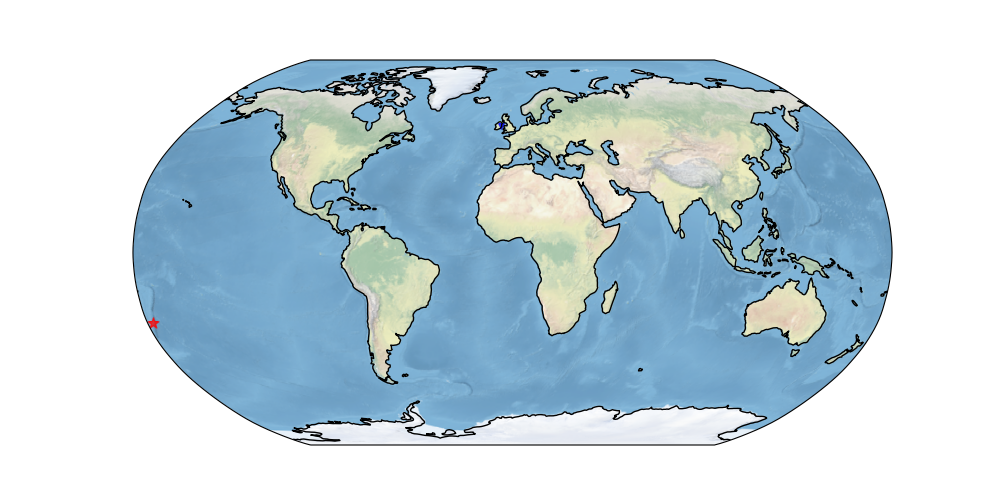

In [33]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
ax.stock_img()
ax.coastlines()

df1 = df_all.drop_duplicates(['stalon','stalat'])
ax.scatter(df1['stalon'].astype(float), df1['stalat'].astype(float), c='b', marker='v', s=15, alpha=0.7,  transform=ccrs.PlateCarree())

if mode == 'event':
    df2 = df_all.drop_duplicates(['evlon','evlat'])
    ax.scatter(df2['evlon'].astype(float), df2['evlat'].astype(float), c='r', marker='*', s=65, alpha=0.7, transform=ccrs.PlateCarree())

# always save this plot
plt.savefig(os.path.join(save_fig_path, 'station_event_map.png'), dpi=300)
plt.show()

### Creating Poly-WAV's

Seperate WAV files are automatically written when data is downloaded. When exporting poly-WAV files and Hydrophone channel is not present for landstation a zero trace is created and exportet instead.

Even if you can download all possible channels (e.g. Water current, temperature, etc... see also here: https://ds.iris.edu/ds/nodes/dmc/tools/data_channels/#VOC) only seismometer channels are exported to WAV files. Only channels starting with:

    XX E       Extremely Short Period  ≥ 80 to < 250< 10 sec
    XX S       Short Period  ≥ 10 to < 80< 10 sec
    
    H       High Broad Band ≥ 80 to < 250≥ 10 sec
    B       Broad Band≥ 10 to < 80≥ 10 sec
    M       Mid Period> 1 to < 10LLong Period≈ 1
    L	    Long Period	≈ 1
    V       Very Long Period≈ 0.1
    
    XX U       Ultra Long Period≈ 0.01
    XX R       Extremely Long Period≥ 0.0001 to < 0.001

will be considered for converting for WAV files. There are even longer/shorter period channels which can be added at a later stage if desired.

For instance

    VOC measures water current
    VKI measures inside Temperature
and

    the “LOG” channel for the console log
    the “SOH” channel for the main state of health channel

are skipped. 

**Note!** framerate and bitrate are set to 48000 and PCM_24 when downloaded for the single WAV files. You can change that for the poly files. If you want to change it for the single files you have to change it in **process_unit_wav.py** at the bottom of the file (don't forget to save your changes!). 

**Attention!** you are setting the mode (event, continous, day) on top of the notebook. Here, you can define another folder to process if you wish. Default is to use the above settings.

### There can be several processed folders depending on your above input

'processed': [yes] 'sampling_rate' and [yes] 'instrument_correction'

'resamp' : [yes] 'sampling_rate' and [no] 'instrument_correction'

'instr': [no] 'sampling_rate' and [yes] 'instrument_correction'

'noinstr_noresamp': [no] 'sampling_rate' and [no] 'instrument_correction'

In [34]:
# ================
# SAC to WAV input 
# ================

# this is the path of the above downloaded data, but you can also put a path to other previously downloaded data
dmt_folder = save_path

# this is the mode from above or adjust to something else you already downloaded
wav_mode = mode

# which folder you want to confert to poly wavs
# put one of these four options:
# 'processed', 'resamp', 'instr', 'noinstr_noresamp'
folder_to_process = 'instr'

# if poly_wav files should be generated. (I left this flag but theoretically if 
# you do not want poly files you already have the single files from the obspyDMT download.)
poly_wav = True

# What and how much to process depending on the wav_mode/mode
proc_wavs_events = ['20210304_192833.a']  # or ['*_*.*'] 
proc_wavs_days = [start_time, 5]  # or for days '*'
proc_wavs_continuous = [start_time, 3]  # or for days '*' | start_time can also be in this format 'YYYY-MM-DD'

station_selection = '*'  # or "RR05" or '*' or ['PL08', 'BIG2']
channel_selection = '*' # please just give the first letter of the channel you want, eg. B, H, L ...

# WAV settings
framerate = 48000
bitrate = 'PCM_24'

# generates automatically plots of SAC files in WAV folder
plot_waveforms = True

# just in case the paths do not exist yet
wav_save, save_fig_path = generate_output_folders(wav_mode, dmt_folder)

In [35]:
# %%capture
stars = '*'*len('Mode: ' + wav_mode)
print(f'{stars}')
print(f'Mode: {wav_mode}')
print(f'{stars}')

# creating a new panada dataframe based on above input 
df_wav = read_station_information(dmt_folder, '*')
# you can change the '*' to a specific event, but this wildcard will give you everything 

if wav_mode == 'continuous':
    # does generate continuous wav files;
    # ATTNENTION uses all continuous* folders in save_path
    export_continuous(df_wav, poly_wav, dmt_folder, folder_to_process, proc_wavs_continuous, station_selection,
                      channel_selection, framerate, bitrate, wav_save, plot_waveforms)

elif wav_mode == 'event':
    # genereates wav files containing specific events
    export_event(df_wav, poly_wav, dmt_folder, folder_to_process, proc_wavs_events, station_selection,
                 channel_selection, framerate, bitrate, wav_save, plot_waveforms)

elif wav_mode == 'day':
    # genereates wav files containing specific days
    export_day(df_wav, poly_wav, dmt_folder, folder_to_process, proc_wavs_days, station_selection,
               channel_selection, framerate, bitrate, wav_save, plot_waveforms)
else: 
    sys.exit(f'Mode: {mode} does not exist or is not implemented. Forced exit!')

***********
Mode: event
***********
Searching SACs in 20210304_192833.a
	Reading for DSB
		Searching in ['BHE', 'BHN', 'BHZ', 'BDH']
			Found DSB.BHE
			Found DSB.BHN
			Found DSB.BHZ
			list index out of range
			No station available in:
			 /mnt/seismodata2/MT/_OUTPUT_/test_obspyDMT_jupyter_final_v02/20210304_192833.a/proc_instr/*DSB*BDH*
			Adding a zero trace for the hydrophone channel...


/mnt/home_geo/mariat/Codes/sac2wav/src_sac2wav.py:768: RuntimeWarning: invalid value encountered in true_divide
  for i, cha in enumerate(collect_cha):


## Plot a particular station that was already downloaded

In [36]:
# ==================
# Post-proc and plot
# ==================
save_figs = True

plot_instrument_response = True  # if save_figs = True -> automatically saves in plot folder, otherwise will not be saved

filtering = True
filter_type = 'bandpass'  # or 'lowpass', 'highpass'
freqmin =  1/50 # Hz
freqmax = 1     # Hz

Attention: The next dataframe (df_all) gives out all download and not necessary what you converted from SAC to WAV (df_wav). 

In [37]:
uniq_sta = df_all['station'].unique()
uniq_cha = df_all['channel'].unique()
uniq_modes = df_all['mode'].unique()
print(f'Available stations:\n{uniq_sta}')
print(f'Available channels:\n{uniq_cha}')
print(f'Available modes/events:\n{uniq_modes}')

Available stations:
['DSB']
Available channels:
['BHE' 'BHN' 'BHZ']
Available modes/events:
['20210304_192833.a']


In [38]:
# you could also define another folder/event that was previously downloaded, default here is save_path
path_to_folder = save_path

# specify event
event = '20210304_192833.a'  # '20210304_192833.a' or "continuous01" 

# specify folder
folder = 'proc_instr'  # 'processed' or "raw"

# station
sta = 'DSB'

cha = 'B*'

### Seismograms and Spectrum

Here you plot all available channels of this one stations. Grouped stations and channels are automatically saved when converting from SAC to WAV.

<IPython.core.display.Javascript object>


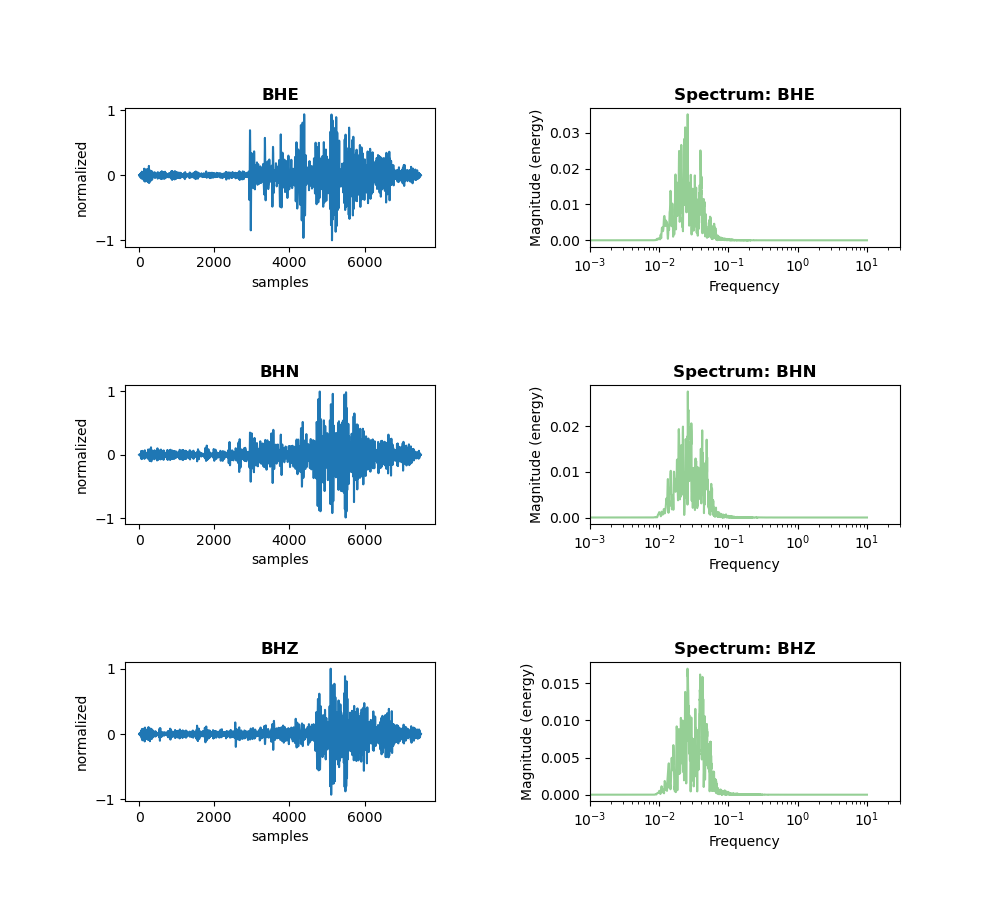

In [39]:
chans = glob.glob(os.path.join(path_to_folder, event, folder, f'*{sta}*{cha}*'))
chans.sort()

fig, axs = plt.subplots(len(chans),2, figsize=(10, 3*len(chans)), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 1, wspace=0.5)

j = 0
for i, trace in enumerate(chans):

    tr = read(trace)[0]
    if filtering:
        tr.filter(filter_type, freqmin=freqmin, freqmax=freqmax)
        # tr.filter('highpass',  freqmin=1/50, freqmax=50)
    try:
        data = tr.data / abs(tr.data).max()
        axs[j].plot(tr.times(), data)
        axs[j].set_title(tr.stats.channel, weight='bold')
        axs[j].set_xlabel('samples')
        axs[j].set_ylabel('normalized')

        axs[j+1].magnitude_spectrum(data, Fs=tr.stats.sampling_rate, color='C2', alpha=0.5)
        axs[j+1].set_title(f'Spectrum: {tr.stats.channel}', weight='bold')
        axs[j+1].set_xscale('log')
        axs[j+1].set_xlim(0.001, 30)

        j += 2
    except Exception as exp:
        axs[j].set_title(tr.stats.channel, weight='bold')
        axs[j].set_xlabel('samples')
        axs[j].set_ylabel('normalized')
        axs[j+1].set_title(f'Spectrum: {tr.stats.channel}', weight='bold')
        axs[j+1].set_xscale('log')
        axs[j+1].set_xlim(0.001, 30)
        j += 2
        continue

if save_figs:
    plt.savefig(os.path.join(save_fig_path, f'{sta}_{event}_{folder}_all_channels.png'), dpi=300)
plt.show()

A spectrogram my take some time depending on the length of the trace and other settings. Hence for now it is done separately.

### Spectrogram

Change following settings

- fmin    
  minimal frequency to be analyzed
- fmax    
  maximal frequency to be analyzed
- nf      
  number of frequencies (will be chosen with logarithmic spacing)
- w0    
  parameter for the wavelet, tradeoff between time and frequency resolution
- fft_zero_pad_fac      
  integer, if > 0, the signal is zero padded to nfft = next_pow_2(len(st)) * fft_zero_pad_fac to get smoother spectrum in the low frequencies
- clim
  limits of the colorbars
- cmap
  colormap for TFEM/TFPM, either a string or matplotlib.cm.Colormap instance
  Check here:
  https://matplotlib.org/stable/tutorials/colors/colormaps.html

Plotting /mnt/seismodata2/MT/_OUTPUT_/test_obspyDMT_jupyter_final_v02/20210304_192833.a/proc_instr/EI.DSB..BHE


<IPython.core.display.Javascript object>


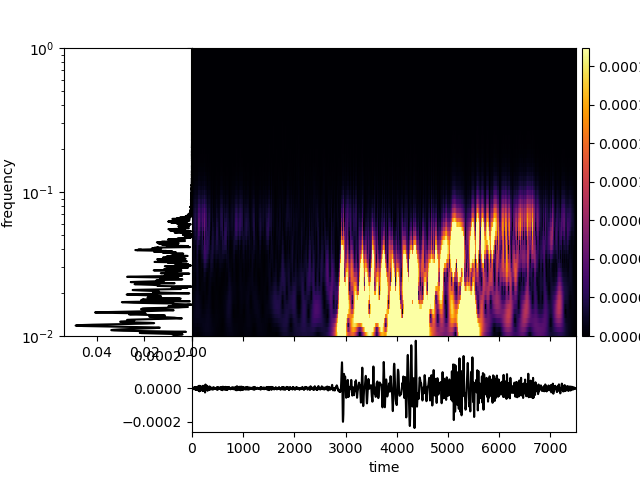

Plotting /mnt/seismodata2/MT/_OUTPUT_/test_obspyDMT_jupyter_final_v02/20210304_192833.a/proc_instr/EI.DSB..BHN


<IPython.core.display.Javascript object>


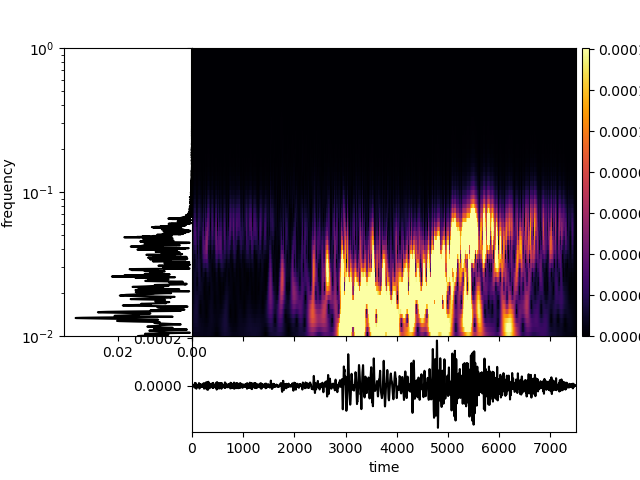

Plotting /mnt/seismodata2/MT/_OUTPUT_/test_obspyDMT_jupyter_final_v02/20210304_192833.a/proc_instr/EI.DSB..BHZ


<IPython.core.display.Javascript object>


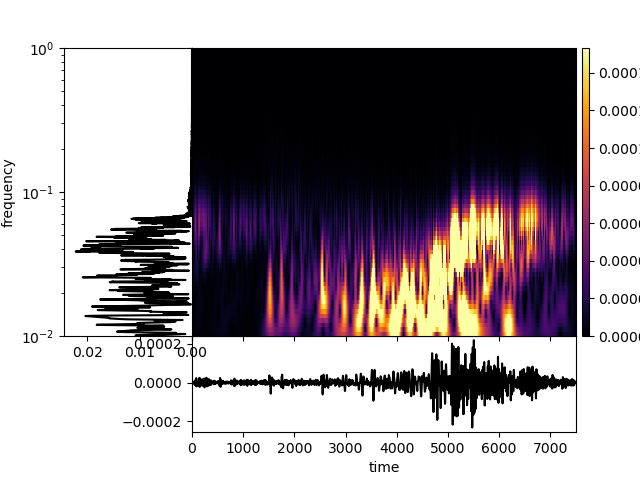

In [43]:
# %%capture
# dt time step between two samples in st (automatically set)
fmin = 0.01
fmax = 1.
w0=4.
nf=64
fft_zero_pad_fac=4
cmap = 'inferno'

chans = glob.glob(os.path.join(path_to_folder, event, folder, f'*{sta}*{cha}*'))
chans.sort()
for trace in chans:
    print(f'Plotting {trace}')
    tr = read(trace)[0]
    plot_tfr(tr.data, 
             dt=tr.stats.delta, 
             fmin=fmin, 
             fmax=fmax, 
             w0=w0, 
             nf=nf, 
             clim= np.mean(tr.data) + 4 * np.std(tr.data),
             cmap=cmap,
             fft_zero_pad_fac=fft_zero_pad_fac)
    if save_figs:
        plt.savefig(os.path.join(save_fig_path, f'{sta}_{tr.stats.channel}_spec_{event}_{folder}.png'), dpi=300)

### Instrument response

In [41]:
from obspy import read, read_inventory

chans = glob.glob(os.path.join(path_to_folder, event, folder, f'*{sta}*{cha}*'))
chans.sort()
inresp = glob.glob(os.path.join(path_to_folder, event, 'resp', f'*{sta}*{cha}*'))
inresp.sort()

pre_filt = [0.001, 0.005, 45, 50]
            
for i, trace in enumerate(chans):
    st = read(trace)
    tr = st[0]
    inv = read_inventory(inresp[i])
    
    if save_figs:
        out_save = os.path.join(save_fig_path, f'{sta}_{tr.stats.channel}_instrument_response_{event}_{folder}.png')
        tr.remove_response(inventory=inv, pre_filt = pre_filt, output="DISP", plot=out_save)
    else:
        tr.remove_response(inventory=inv, pre_filt= pre_filt,output="DISP", plot=True)      